# Построение и анализ моделей беспроводных сетей 5G/6G
## Практическая работа №5
### Преобразования СВ для потерь, SNR и скорости Шеннона

Быстров Глеб Андреевич
НФИмд-01-24
1132249517

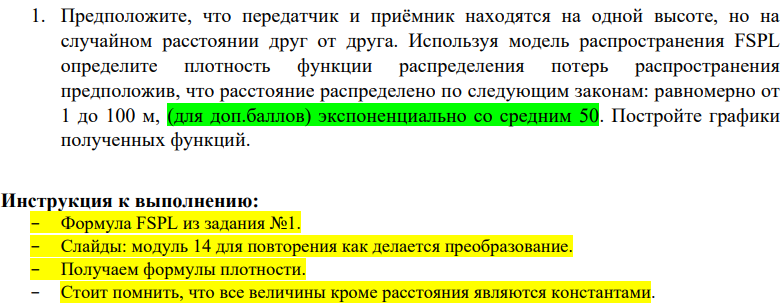

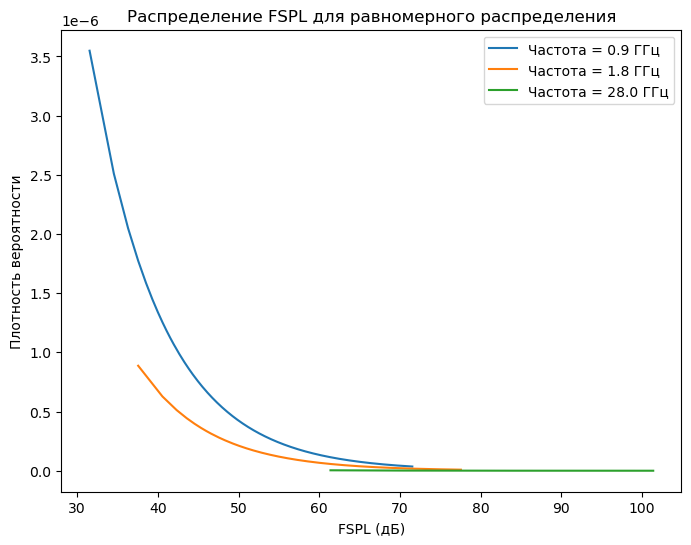

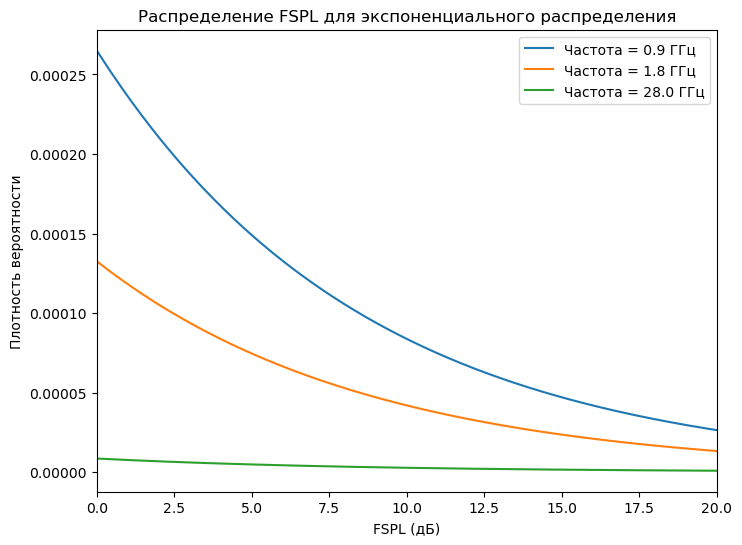

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light

def convert_to_linear(db_value):
    return 10 ** (db_value / 10)

def convert_to_log(linear_value):
    return 10 * np.log10(linear_value)

frequency_set = [0.9e9, 1.8e9, 28e9]
transmitter_power = convert_to_linear(23)
antenna_gain_tx = convert_to_linear(10)
antenna_gain_rx = convert_to_linear(10)
noise_level = convert_to_linear(-174)
bandwidth = 20e6
noise_power = noise_level * bandwidth

def calculate_fspl(distance_squared, frequency):
    lower_bound = (4 * np.pi * frequency / speed_of_light) ** 2
    upper_bound = (400 * np.pi * frequency / speed_of_light) ** 2
    if lower_bound <= distance_squared <= upper_bound:
        return speed_of_light / (792 * np.pi * frequency * np.sqrt(distance_squared))
    return 0

distance_squared_values = {}
density_values_uniform = {}

for freq in frequency_set:
    lower_bound = (4 * np.pi * freq / speed_of_light) ** 2
    upper_bound = (400 * np.pi * freq / speed_of_light) ** 2
    distances = np.linspace(lower_bound, upper_bound, 10000)
    density = [calculate_fspl(d, freq) for d in distances]
    distance_squared_values[freq] = distances
    density_values_uniform[freq] = density

plt.figure(figsize=(8, 6))
for freq, distances in distance_squared_values.items():
    plt.plot([convert_to_log(d) for d in distances], density_values_uniform[freq],
             label=f'Частота = {freq / 1e9} ГГц')
plt.title("Распределение FSPL для равномерного распределения")
plt.xlabel("FSPL (дБ)")
plt.ylabel("Плотность вероятности")
plt.legend()
plt.show()

def calculate_fspl_exponential(distance, frequency):
    if distance > 0:
        exponent = -0.02 * speed_of_light * np.sqrt(distance) / (4 * np.pi * frequency)
        coefficient = speed_of_light / (8 * np.pi * frequency * np.sqrt(distance))
        return 0.02 * np.exp(exponent) * abs(coefficient)
    return 0

distance_range = np.linspace(1, 100, 1000)
density_values_exponential = {}

for freq in frequency_set:
    density = [calculate_fspl_exponential(d, freq) for d in distance_range]
    density_values_exponential[freq] = density

plt.figure(figsize=(8, 6))
for freq in frequency_set:
    plt.plot([convert_to_log(d) for d in distance_range], density_values_exponential[freq],
             label=f'Частота = {freq / 1e9} ГГц')
plt.title("Распределение FSPL для экспоненциального распределения")
plt.xlabel("FSPL (дБ)")
plt.ylabel("Плотность вероятности")
plt.xlim(convert_to_log(1), convert_to_log(100))
plt.legend()
plt.show()

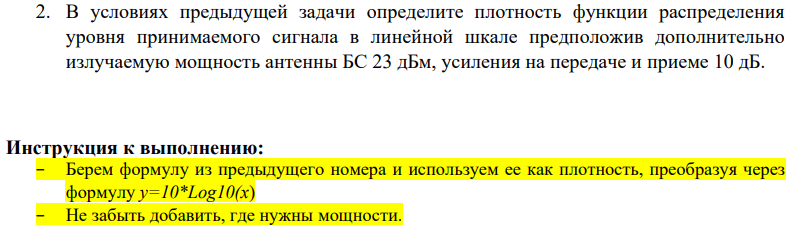

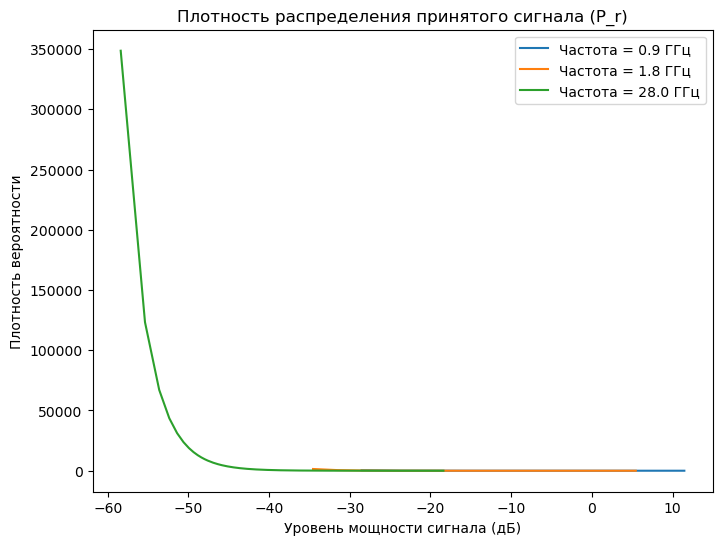

In [10]:
def compute_signal_density(power_level, transmit_power, gain_tx, gain_rx, frequency):
    lower_bound = transmit_power * gain_tx * gain_rx * (speed_of_light / (400 * np.pi * frequency)) ** 2
    upper_bound = transmit_power * gain_tx * gain_rx * (speed_of_light / (4 * np.pi * frequency)) ** 2
    if lower_bound <= power_level <= upper_bound:
        numerator = np.sqrt(transmit_power * gain_tx * gain_rx) * speed_of_light
        denominator = 792 * np.pi * frequency * power_level * np.sqrt(power_level)
        return numerator / denominator
    return 0

frequency_values = [0.9e9, 1.8e9, 28e9]
power_bounds = {}
density_data = {}

for freq in frequency_values:
    lower_bound = transmitter_power * antenna_gain_tx * antenna_gain_rx * (speed_of_light / (400 * np.pi * freq)) ** 2
    upper_bound = transmitter_power * antenna_gain_tx * antenna_gain_rx * (speed_of_light / (4 * np.pi * freq)) ** 2
    power_bounds[freq] = (lower_bound, upper_bound)
    power_levels = np.linspace(lower_bound, upper_bound, 10000)
    density = [compute_signal_density(p, transmitter_power, antenna_gain_tx, antenna_gain_rx, freq) for p in power_levels]
    density_data[freq] = (power_levels, density)

plt.figure(figsize=(8, 6))
for freq in frequency_values:
    power_levels, density = density_data[freq]
    plt.plot([10 * np.log10(p) for p in power_levels], density, label=f'Частота = {freq / 1e9} ГГц')

plt.title("Плотность распределения принятого сигнала (P_r)")
plt.xlabel("Уровень мощности сигнала (дБ)")
plt.ylabel("Плотность вероятности")
plt.legend()
plt.show()

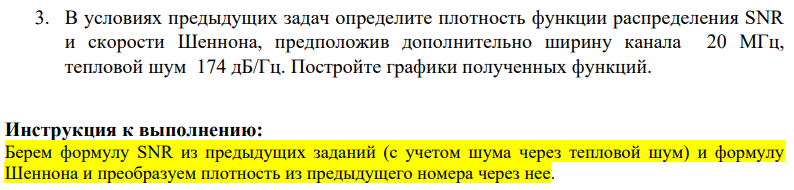

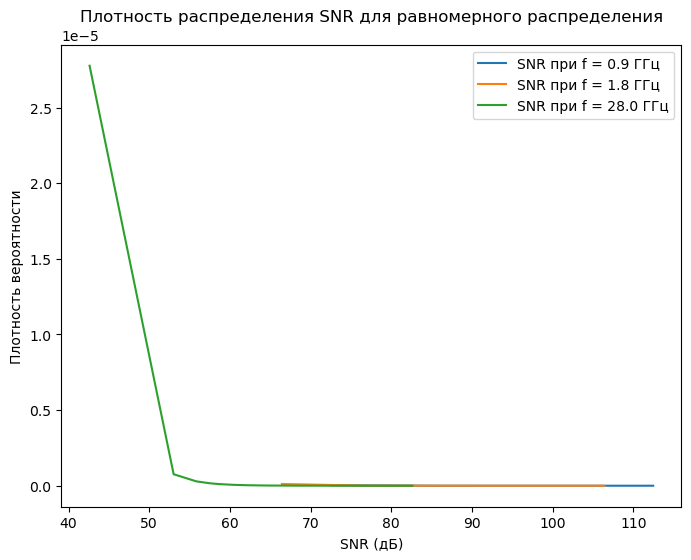

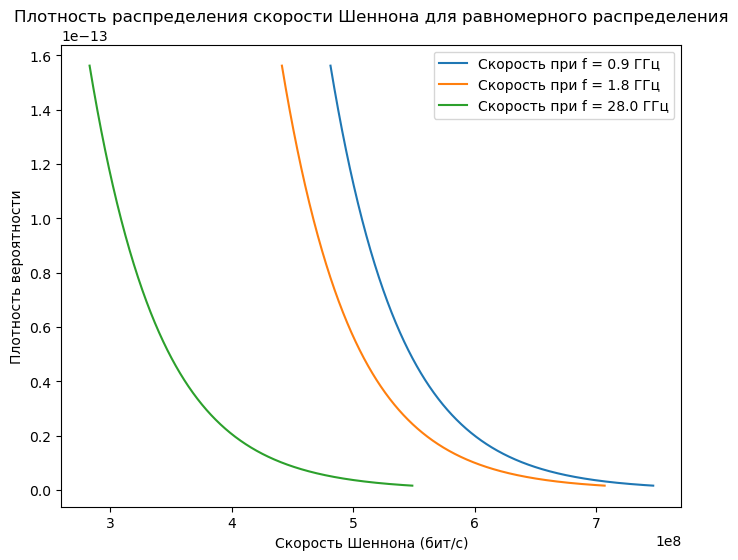

In [12]:
def calculate_snr(power_level, transmit_power, gain_tx, gain_rx, frequency, noise_power):
    lower_bound = (transmit_power * gain_tx * gain_rx / noise_power) * (speed_of_light / (400 * np.pi * frequency)) ** 2
    upper_bound = (transmit_power * gain_tx * gain_rx / noise_power) * (speed_of_light / (4 * np.pi * frequency)) ** 2
    if lower_bound <= power_level <= upper_bound:
        numerator = np.sqrt(transmit_power * gain_tx * gain_rx) * speed_of_light
        denominator = 792 * np.pi * frequency * power_level * np.sqrt(power_level * noise_power)
        return numerator / denominator
    return 0

def calculate_shannon_capacity(capacity, transmit_power, gain_tx, gain_rx, frequency, bandwidth, noise_power):
    lower_bound = bandwidth * np.log2((transmit_power * gain_tx * gain_rx / noise_power) *
                                      (speed_of_light / (400 * np.pi * frequency)) ** 2 + 1)
    upper_bound = bandwidth * np.log2((transmit_power * gain_tx * gain_rx / noise_power) *
                                      (speed_of_light / (4 * np.pi * frequency)) ** 2 + 1)
    if lower_bound <= capacity <= upper_bound:
        scaling_factor = np.log(2) * speed_of_light * np.sqrt(transmit_power * gain_tx * gain_rx)
        adjusted_value = 2 ** (capacity / bandwidth) - 1
        return scaling_factor * (2 ** (capacity / bandwidth)) / (792 * np.pi * frequency * adjusted_value * np.sqrt(adjusted_value) * bandwidth)
    return 0

frequencies = [0.9e9, 1.8e9, 28e9]
bandwidth = 20e6
noise_power = 10 ** (-174 / 10) * bandwidth
transmit_power = 10 ** (23 / 10)
gain_tx = 10 ** (10 / 10)
gain_rx = 10 ** (10 / 10)

plt.figure(figsize=(8, 6))
for freq in frequencies:
    snr_bounds = (
        (transmit_power * gain_tx * gain_rx / noise_power) * (speed_of_light / (400 * np.pi * freq)) ** 2,
        (transmit_power * gain_tx * gain_rx / noise_power) * (speed_of_light / (4 * np.pi * freq)) ** 2,
    )
    snr_values = np.linspace(snr_bounds[0], snr_bounds[1], 1000)
    snr_density = [calculate_snr(snr, transmit_power, gain_tx, gain_rx, freq, noise_power) for snr in snr_values]
    plt.plot([10 * np.log10(s) for s in snr_values], snr_density, label=f'SNR при f = {freq / 1e9} ГГц')

plt.title("Плотность распределения SNR для равномерного распределения")
plt.xlabel("SNR (дБ)")
plt.ylabel("Плотность вероятности")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for freq in frequencies:
    capacity_bounds = (
        bandwidth * np.log2((transmit_power * gain_tx * gain_rx / noise_power) *
                            (speed_of_light / (400 * np.pi * freq)) ** 2 + 1),
        bandwidth * np.log2((transmit_power * gain_tx * gain_rx / noise_power) *
                            (speed_of_light / (4 * np.pi * freq)) ** 2 + 1),
    )
    capacity_values = np.linspace(capacity_bounds[0], capacity_bounds[1], 1000)
    capacity_density = [calculate_shannon_capacity(c, transmit_power, gain_tx, gain_rx, freq, bandwidth, noise_power)
                        for c in capacity_values]
    plt.plot(capacity_values, capacity_density, label=f'Скорость при f = {freq / 1e9} ГГц')

plt.title("Плотность распределения скорости Шеннона для равномерного распределения")
plt.xlabel("Скорость Шеннона (бит/с)")
plt.ylabel("Плотность вероятности")
plt.legend()
plt.show()

#### Заключение

1. Распределение FSPL для равномерного и экспоненциального распределений:
* С увеличением частоты сигналов плотность вероятности FSPL уменьшается. Это связано с увеличением потерь на распространение при более высоких частотах. При экспоненциальном распределении плотность вероятности стремительно убывает, что подтверждает более быстрое затухание сигналов на коротких расстояниях.

2. Распределение принятого сигнала:
* Принятый сигнал также показывает уменьшение плотности вероятности с увеличением частоты. Это подтверждает, что при более высоких частотах затухание сигнала сильнее, что приводит к снижению мощности принятого сигнала.

3. Распределение SNR:
* Более высокие частоты имеют меньшую плотность вероятности SNR, что связано с увеличением потерь и шумов при этих частотах. Плотность SNR выше при низких частотах, что демонстрирует лучшую передаваемую мощность и меньшие потери.

4. Скорость Шеннона:
* При увеличении частоты возможная скорость передачи данных уменьшается из-за большего влияния шума и потерь на высоких частотах. Скорость передачи данных максимальна на низких частотах, так как они лучше сопротивляются затуханию и имеют более высокое отношение сигнал/шум.


- Высокочастотные сигналы подходят для короткодействующих систем, таких как 5G-сети.
- Низкочастотные сигналы имеют меньшее затухание и шумы, что делает их подходящими для долгосрочной связи.
- Для достижения оптимальной скорости и минимальных потерь необходимо тщательно выбирать рабочую частоту в зависимости от целей системы связи.